### 버스 운행시간 예측
- https://dacon.io/competitions/official/229611/codeshare/606 3등 코드리뷰
- [교통] 공공 교통 빅데이터와 AI 를 이용하여 교통이용 분석 - 버스, 회귀,  (2등 코드 리뷰)
 
### 1. 배경
- 제주도내 주민등록인구는 2019년 11월 기준 69만명으로, 연평균 4%대로 성장했습니다. 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정됩니다. 제주도민 증가와 외국인의 증가로 현재 제주도의 교통체증이 심각한 문제로 떠오르고 있습니다. 2017년 한국은행 제주본부에 따르면 제주도 일부 지역은 교통체증이 서울보다 심각합니다. 따라서, 제주테크노파크는 교통난 심화를 해결하기 위해 데이터 분석 대회를 개최합니다.

### 2. 목적
- 제주도 버스의 효율적인 운행를 위해 운행 시간을 예측하는 모델 만들기 ! 

### 3. 변수
- next_arrive_time 이 목적변수 !

In [27]:
# 1. 데이터 탐색 - (0) 관련 라이브러리 로딩
import numpy as np # 행렬 연산 / 데이터 핸들링
import pandas as pd # 데이터 분석

import warnings
warnings.filterwarnings(action='ignore') # 반대는 default

import os
os.chdir('C:\\Users\\urse\\Desktop\\dataset\\Dacon-BusJeju2')

# 데이터 불러오기
train_data = pd.read_csv('train.csv', engine='python') # 학습 데이터
test_data = pd.read_csv('test.csv', engine='python') # 시험 데이터

print('데이터 로딩 완료')

데이터 로딩 완료


In [28]:
# 1. 데이터 탐색 - (1) 훈련 데이터 확인
print(train_data.shape)
train_data.head()

(210457, 14)


,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [29]:
# 1. 데이터 탐색 - (2) 테스트 데이터 확인
print(test_data.shape)
test_data.head()

## => next_arrive_time이 목적변수 !

(91774, 13)


,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355


In [31]:
# 1. 데이터 탐색 - (3) dtypes 확인
print('#### train_dtypes\n', train_data.dtypes)
print('\n#### test_dtypes\n', test_data.dtypes)
# -> train data와 test data의 데이터 형식은 일치
# -> date 변수 datetime 변수형으로 변환 필요

#### train_dtypes
 id                    int64
date                 object
route_id              int64
vh_id                 int64
route_nm             object
now_latitude        float64
now_longitude       float64
now_station          object
now_arrive_time      object
distance            float64
next_station         object
next_latitude       float64
next_longitude      float64
next_arrive_time      int64
dtype: object

#### test_dtypes
 id                   int64
date                object
route_id             int64
vh_id                int64
route_nm            object
now_latitude       float64
now_longitude      float64
now_station         object
now_arrive_time     object
distance           float64
next_station        object
next_latitude      float64
next_longitude     float64
dtype: object


In [32]:
# 1. 데이터탐색 - (4) train - object형 unique - date, route_nm, now_station, now_arrive_time, next_station 5개
print('### test data')
for i in train_data.columns:
    if train_data[i].dtypes=='object':
        t_unique = train_data[i].unique()
        if len(t_unique) > 10:
            print(i, t_unique[:10], '==>', len(t_unique), '개\n')
        else :
            print(i, t_unique, '==>', len(t_unique), '개\n')
            
# date => 14개 (2019년 10월 15일 ~ 2019년 10월 28일 총 14일)
# route_nm => 21개
# now_station => 348개
# now_arrive_time => 20개 ( 05시 ~ 00시)
# next_station => 351개

### test data
date ['2019-10-15' '2019-10-16' '2019-10-17' '2019-10-18' '2019-10-19'
 '2019-10-20' '2019-10-21' '2019-10-22' '2019-10-23' '2019-10-24'] ==> 14 개

route_nm ['360-1' '360-2' '360-7' '360-12' '365-21' '365-22' '201-11' '201-12'
 '201-13' '201-14'] ==> 21 개

now_station ['제주대학교입구' '제대마을' '제대아파트' '남국원(아라방면)' '도호동' '한라중학교/부영아파트' '대림2차아파트' '롯데마트'
 '원노형' '노형오거리'] ==> 348 개

now_arrive_time ['06시' '07시' '08시' '09시' '10시' '11시' '13시' '14시' '16시' '17시'] ==> 20 개

next_station ['제대마을' '제대아파트' '제주대학교' '제주여자중고등학교(아라방면)' '은남동' '대림2차아파트' '연동대림1차아파트'
 '원노형' '노형오거리' '남녕고등학교'] ==> 351 개



In [33]:
# 1. 데이터탐색 - (5) test - object형 unique - date, route_nm, now_station, now_arrive_time, next_station 5개
print('### test data')
for i in test_data.columns:
    if test_data[i].dtypes=='object':
        t_unique = test_data[i].unique()
        if len(t_unique) > 10:
            print(i, t_unique[:10], '==>', len(t_unique), '개\n')
        else :
            print(i, t_unique, '==>', len(t_unique), '개\n')
            
# date => 8개 (19년 10월 29일 ~ 19년 11월 5일  총 8일)
# route_nm => 21개
# now_station => 349개
# now_arrive_time => 19개 (05시 ~ 23시)
# next_station => 350개

### test data
date ['2019-10-29' '2019-10-30' '2019-10-31' '2019-11-01' '2019-11-02'
 '2019-11-03' '2019-11-04' '2019-11-05'] ==> 8 개

route_nm ['360-1' '360-2' '360-7' '360-12' '365-21' '365-22' '201-11' '201-12'
 '201-13' '201-14'] ==> 21 개

now_station ['제대마을' '제대아파트' '한라중학교/부영아파트' '대림2차아파트' '연동대림1차아파트' '케이티앤지' '롯데마트' '원노형'
 '남녕고등학교' '한라병원'] ==> 349 개

now_arrive_time ['07시' '08시' '09시' '10시' '11시' '12시' '13시' '14시' '15시' '17시'] ==> 19 개

next_station ['제대아파트' '제주대학교' '대림2차아파트' '연동대림1차아파트' '케이티앤지' '롯데마트' '원노형' '노형오거리' '한라병원'
 '삼무공원사거리'] ==> 350 개



In [34]:
# 1. 데이터 탐색 - (6) train - 수치형 데이터 중 유의미한 수치형 2개 -> distance, next_arrive_time
train_numeric = train_data[['distance', 'next_arrive_time']]
print(train_numeric.shape)
train_numeric.describe()

# -> 수치형변수 next_arrive_time의 최고값이 698 그 이후값은 제거해도 된다?

(210457, 2)


,distance,next_arrive_time
count,210457.000000,210457.000000
mean,490.256100,85.380824
std,520.563932,85.051170
min,97.000000,6.000000
25%,291.000000,44.000000
50%,384.000000,66.000000
75%,542.000000,102.000000
max,7461.000000,2996.000000


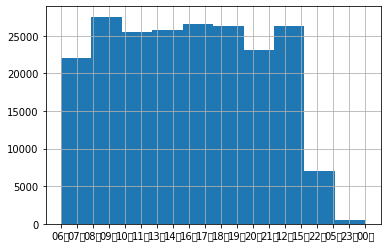

In [35]:
# 1. 데이터 탐색 - (7) train data 현재 도착시간과 예측시간의 분포 분석 - histogram
train_var = train_data['now_arrive_time']
train_var.hist()

# -> 확인결과 22시, 23시, 00시, 05시, 데이터가 비교적 적음. 나머진 균등 

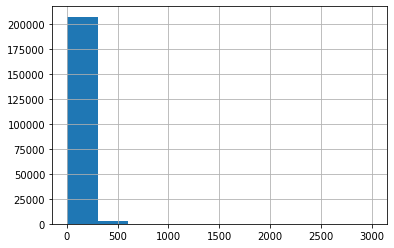

In [36]:
# 1. 데이터 탐색 - (7) train data 현재 도착시간과 예측시간의 분포 분석 - histogram
train_target = train_data['next_arrive_time']
train_target.hist()

# => 확인 결과 대부분의 데이터가 0~200사이, 200넘어가는건 적음
# => 700이상에서 잘라내는 것 좋음.

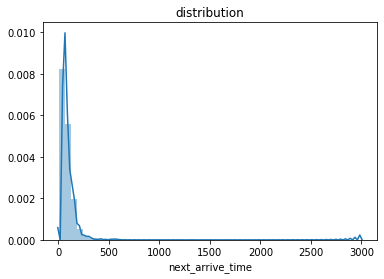

In [37]:
# 1. 데이터 탐색 - (7) 정규 분포 보기
import matplotlib.pyplot as plt
import seaborn as sns
plt.title('distribution')
sns.distplot(train_data['next_arrive_time'])
# => 확인 결과 대부분의 데이터가 0~200사이, 200넘어가는건 적음
# => 700이상에서 잘라내는 것 좋음.

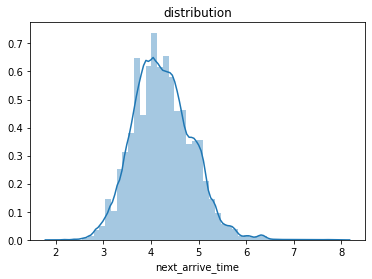

In [47]:
# 1. 데이터 탐색 - (7) 정규 분포 로그 취해서 보기
# 정규분포로 로그를 취함 로그는 log1p = (log 1 + x )라는 것
train_data['next_arrive_time'] = np.log1p(train_data['next_arrive_time'])
plt.title('distribution')
sns.distplot(train_data['next_arrive_time'])

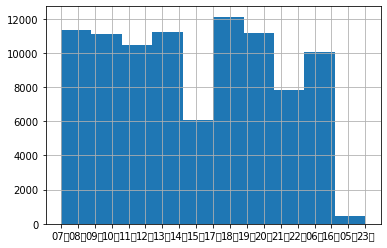

In [38]:
# 1. 데이터 탐색 - (8) test_data 현재 도착시간의 분포 분석 - histogram
test_var = test_data['now_arrive_time']
test_var.hist()

# -> 확인결과 05시, 23시 데이터가 적음. 
# -> 훈련 데이터가 22시 데이터가 적어서 22시 결과는 잘 안나올수도 있지 않을까 생각이 듬

### 데이터 탐색 정리
- train data와 test data의 데이터 형식은 일치
- date 변수 datetime 변수형으로 변환 필요
- train과 test사이에 변수간 차이 발생 
> 훈련데이터가 테스트 데이터보다 많은건 괜찮지만 테스트 데이터가 훈련 데이터보다 많은 건 안좋을 수 있음   
> now_station 과 next_station 없는것 빼기?   
> now_arrive_time은 시간은 훈련데이터가 더 많으니까 괜찮음   
> now_station과 next_station은 같은 항목이란걸 알수 있음   
- 수치형 변수 next_arrive_time의 최고값이 698. 그 초과값은 제거해도 된다? (describe, histogram에 의한 판단)
- train data는 22시 데이터가 적어서 22시 test 결과가 잘 안나올 수도 있지 않을까?
- route_nm과 route_id는 같은 역할의 데이터? 제거?  
- id는 학습에서 의미 없으니 이도 제거?
- 의문1) 트리 기반에서는 정규분포를 띄고 있는지 아닌지는 크게 중요하지 않음. -> 굳이 outlier를 제거해줄필요?

In [39]:
# 2. 데이터 전처리 - (1) 사용하지 않는 셀 삭제
train_data.drop(['route_id', 'vh_id', 'now_station', 'next_station'], axis=1 , inplace=True)

# 보기 편해졌다.
train_data.head(5)

,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,360-1,33.456267,126.551750,06시,266.0,33.457724,126.554014,24
1,1,2019-10-15,360-1,33.457724,126.554014,06시,333.0,33.458783,126.557353,36
2,2,2019-10-15,360-1,33.458783,126.557353,06시,415.0,33.459893,126.561624,40
3,3,2019-10-15,360-1,33.479705,126.543811,06시,578.0,33.484860,126.542928,42
4,4,2019-10-15,360-1,33.485662,126.494923,07시,374.0,33.485822,126.490897,64


In [40]:
# 2. 데이터 전처리 - (2) route_nm 그룹짓기 
# -> 360 그룹 버스들, 365 그룹 버스들, 201 그룹 버스들, 281그룹 버스들
train_data_group = train_data.copy()
train_data_group['bus_group']='group'

# 360 그룹 버스들
train_data_group.loc[ (train_data_group['route_nm']=='360-1') | (train_data_group['route_nm']=='360-2') | (train_data_group['route_nm']=='360-7') | (train_data_group['route_nm']=='360-12')
               , ['bus_group'] ] = '360'

# 365 그룹 버스들
train_data_group.loc[ (train_data_group['route_nm']=='365-21') | (train_data_group['route_nm']=='365-22'), ['bus_group'] ] = '365'

# 201 그룹 버스들
train_data_group.loc[ (train_data_group['route_nm']=='201-11') | (train_data_group['route_nm']=='201-12') | (train_data_group['route_nm']=='201-13') | (train_data_group['route_nm']=='201-14') 
               | (train_data_group['route_nm']=='201-16') | (train_data_group['route_nm']=='201-17') | (train_data_group['route_nm']=='201-18') | (train_data_group['route_nm']=='201-21') 
               | (train_data_group['route_nm']=='201-22') | (train_data_group['route_nm']=='201-24') | (train_data_group['route_nm']=='201-26') | (train_data_group['route_nm']=='201-27')
               , ['bus_group'] ] = '201'

# 281 그룹 버스들
train_data_group.loc[ (train_data_group['route_nm']=='281-1') | (train_data_group['route_nm']=='281-2'), ['bus_group'] ] = '281'

# bus_group 별 원핫 인코더
train_data_group = pd.get_dummies(train_data_group,columns=['bus_group'])
print(train_data_group.shape)
train_data_group.head()

(210457, 15)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,next_arrive_time,bus_group_201,bus_group_281,bus_group_360,bus_group_365,bus_group_group
0,0,2019-10-15,360-1,33.456267,126.551750,06시,266.0,33.457724,126.554014,24,0,0,1,0,0
1,1,2019-10-15,360-1,33.457724,126.554014,06시,333.0,33.458783,126.557353,36,0,0,1,0,0
2,2,2019-10-15,360-1,33.458783,126.557353,06시,415.0,33.459893,126.561624,40,0,0,1,0,0
3,3,2019-10-15,360-1,33.479705,126.543811,06시,578.0,33.484860,126.542928,42,0,0,1,0,0
4,4,2019-10-15,360-1,33.485662,126.494923,07시,374.0,33.485822,126.490897,64,0,0,1,0,0


In [15]:
# 2. 데이터 전처리 - (2) route_nm 그룹짓기 - test data
# -> 360 그룹 버스들, 365 그룹 버스들, 201 그룹 버스들, 281그룹 버스들df_test.drop(['route_id', 'vh_id', 'now_station', 'next_station'], axis=1 , inplace=True)
test_data_group = test_data.copy()

# 필요없는 변수들 drop
test_data_group.drop(['route_id', 'vh_id', 'now_station', 'next_station'], axis=1 , inplace=True)

# 버스 그룹 짓기
test_data_group['bus_group']='group'

# 360 그룹 버스들
test_data_group.loc[ (test_data_group['route_nm']=='360-1') | (test_data_group['route_nm']=='360-2') | (test_data_group['route_nm']=='360-7') | (test_data_group['route_nm']=='360-12'), ['bus_group'] ] = '360'

# 365 그룹 버스들
test_data_group.loc[ (test_data_group['route_nm']=='365-21') | (test_data_group['route_nm']=='365-22'), ['bus_group'] ] = '365'

# 201 그룹 버스들
test_data_group.loc[ (test_data_group['route_nm']=='201-11') | (test_data_group['route_nm']=='201-12') | (test_data_group['route_nm']=='201-13') 
                    | (test_data_group['route_nm']=='201-14') | (test_data_group['route_nm']=='201-16') | (test_data_group['route_nm']=='201-17') 
                    | (test_data_group['route_nm']=='201-18') | (test_data_group['route_nm']=='201-21') | (test_data_group['route_nm']=='201-22') 
                    | (test_data_group['route_nm']=='201-24') | (test_data_group['route_nm']=='201-26') | (test_data_group['route_nm']=='201-27'), ['bus_group'] ] = '201'

# 281 그룹 버스들
test_data_group.loc[ (test_data_group['route_nm']=='281-1') | (test_data_group['route_nm']=='281-2'), ['bus_group'] ] = '281'
# bus group 원 핫 인코딩
test_data_group = pd.get_dummies(test_data_group,columns=['bus_group'])

print(test_data_group.shape)
test_data_group.head()

(91774, 14)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,bus_group_201,bus_group_281,bus_group_360,bus_group_365,bus_group_group
0,210457,2019-10-29,360-1,33.457724,126.554014,07시,333.0,33.458783,126.557353,0,0,1,0,0
1,210458,2019-10-29,360-1,33.458783,126.557353,07시,415.0,33.459893,126.561624,0,0,1,0,0
2,210459,2019-10-29,360-1,33.478867,126.483833,08시,417.0,33.478850,126.488350,0,0,1,0,0
3,210460,2019-10-29,360-1,33.478850,126.488350,08시,334.0,33.480700,126.489933,0,0,1,0,0
4,210461,2019-10-29,360-1,33.480700,126.489933,08시,550.0,33.482077,126.485355,0,0,1,0,0


In [16]:
# 2. 데이터 전처리 - (3) datetime 변환 후 date와 요일 변환 - train
train_data_date = train_data_group.copy()
del train_data_date['bus_group_group']
train_data_date['date'] = pd.to_datetime(train_data_date['date'])

train_data_date['weekday'] = train_data_date['date'].dt.weekday

# 요일 원 핫 인코딩
train_data_date = pd.get_dummies(train_data_date,columns=['weekday'])

# head()
print(train_data_date.shape)
train_data_date.head()

(210457, 21)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,next_arrive_time,...,bus_group_281,bus_group_360,bus_group_365,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,2019-10-15,360-1,33.456267,126.551750,06시,266.0,33.457724,126.554014,3.218876,...,0,1,0,0,1,0,0,0,0,0
1,1,2019-10-15,360-1,33.457724,126.554014,06시,333.0,33.458783,126.557353,3.610918,...,0,1,0,0,1,0,0,0,0,0
2,2,2019-10-15,360-1,33.458783,126.557353,06시,415.0,33.459893,126.561624,3.713572,...,0,1,0,0,1,0,0,0,0,0
3,3,2019-10-15,360-1,33.479705,126.543811,06시,578.0,33.484860,126.542928,3.761200,...,0,1,0,0,1,0,0,0,0,0
4,4,2019-10-15,360-1,33.485662,126.494923,07시,374.0,33.485822,126.490897,4.174387,...,0,1,0,0,1,0,0,0,0,0


In [17]:
# 2. 데이터 전처리 - (3) datetime 변환 후 date와 요일 변환 - test
# 복사
test_data_date = test_data_group.copy()
del test_data_date['bus_group_group']

test_data_date['date'] = pd.to_datetime(test_data_date['date'])
test_data_date['weekday'] = test_data_date['date'].dt.weekday

# 요일 원 핫 인코딩
test_data_date = pd.get_dummies(test_data_date,columns=['weekday'])

# head()
print(test_data_date.shape)
train_data_date.head()

(91774, 20)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,next_arrive_time,...,bus_group_281,bus_group_360,bus_group_365,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,2019-10-15,360-1,33.456267,126.551750,06시,266.0,33.457724,126.554014,3.218876,...,0,1,0,0,1,0,0,0,0,0
1,1,2019-10-15,360-1,33.457724,126.554014,06시,333.0,33.458783,126.557353,3.610918,...,0,1,0,0,1,0,0,0,0,0
2,2,2019-10-15,360-1,33.458783,126.557353,06시,415.0,33.459893,126.561624,3.713572,...,0,1,0,0,1,0,0,0,0,0
3,3,2019-10-15,360-1,33.479705,126.543811,06시,578.0,33.484860,126.542928,3.761200,...,0,1,0,0,1,0,0,0,0,0
4,4,2019-10-15,360-1,33.485662,126.494923,07시,374.0,33.485822,126.490897,4.174387,...,0,1,0,0,1,0,0,0,0,0


In [41]:
# 2. 데이터 전처리 - (4) time group 생성 및 group화 - train

train_data_time = train_data_date.copy()

train_data_time['time_group']='group' #time_group 변수를 미리 생성

train_data_time.loc[ (train_data_time['now_arrive_time']>='05시') & (train_data_time['now_arrive_time']<'07시') ,['time_group'] ]= 'morning_1' # 5~6시
train_data_time.loc[ (train_data_time['now_arrive_time']>='07시') & (train_data_time['now_arrive_time']<'09시') ,['time_group'] ]= 'morning_2' # 7~8시
train_data_time.loc[ (train_data_time['now_arrive_time']>='09시') & (train_data_time['now_arrive_time']<'11시') ,['time_group'] ]= 'afternoon_1' # 9~10시
train_data_time.loc[ (train_data_time['now_arrive_time']>='11시') & (train_data_time['now_arrive_time']<'13시') ,['time_group'] ]= 'afternoon_2' # 11~12시
train_data_time.loc[ (train_data_time['now_arrive_time']>='13시') & (train_data_time['now_arrive_time']<'15시') ,['time_group'] ]= 'afternoon_3' #13~14시
train_data_time.loc[ (train_data_time['now_arrive_time']>='15시') & (train_data_time['now_arrive_time']<'17시') ,['time_group'] ]= 'evening_1' #15~16시
train_data_time.loc[ (train_data_time['now_arrive_time']>='17시') & (train_data_time['now_arrive_time']<'19시') ,['time_group'] ]= 'evening_2' #17~18시
train_data_time.loc[ (train_data_time['now_arrive_time']>='19시') & (train_data_time['now_arrive_time']<'21시'),['time_group'] ]= 'evening_3' #19~20시
train_data_time.loc[ (train_data_time['now_arrive_time']>='21시') & (train_data_time['now_arrive_time']<'23시'),['time_group'] ]= 'night_1' #21~22시
train_data_time.loc[ (train_data_time['now_arrive_time']>='23시') | (train_data_time['now_arrive_time']=='00시'),['time_group'] ]= 'night_2' #23~00시

train_data_time = pd.get_dummies(train_data_time, columns=['time_group'])
print(train_data_time.shape)
train_data_time.head()

# 트리기반이라 변수가 너무 많다보면 각 분류별로 표본의 갯수가 비슷할 테니 줄여주는게 좋음.

(210457, 31)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,next_arrive_time,...,time_group_afternoon_1,time_group_afternoon_2,time_group_afternoon_3,time_group_evening_1,time_group_evening_2,time_group_evening_3,time_group_morning_1,time_group_morning_2,time_group_night_1,time_group_night_2
0,0,2019-10-15,360-1,33.456267,126.551750,06시,266.0,33.457724,126.554014,3.218876,...,0,0,0,0,0,0,1,0,0,0
1,1,2019-10-15,360-1,33.457724,126.554014,06시,333.0,33.458783,126.557353,3.610918,...,0,0,0,0,0,0,1,0,0,0
2,2,2019-10-15,360-1,33.458783,126.557353,06시,415.0,33.459893,126.561624,3.713572,...,0,0,0,0,0,0,1,0,0,0
3,3,2019-10-15,360-1,33.479705,126.543811,06시,578.0,33.484860,126.542928,3.761200,...,0,0,0,0,0,0,1,0,0,0
4,4,2019-10-15,360-1,33.485662,126.494923,07시,374.0,33.485822,126.490897,4.174387,...,0,0,0,0,0,0,0,1,0,0


In [19]:
# 2. 데이터 전처리 - (4) time group 생성 및 group화 - test

test_data_time = test_data_date.copy()

test_data_time['time_group']='group' #time_group 변수를 미리 생성

test_data_time.loc[ (test_data_time['now_arrive_time']>='05시') & (test_data_time['now_arrive_time']<'07시') ,['time_group'] ]= 'morning_1' # 5~6시
test_data_time.loc[ (test_data_time['now_arrive_time']>='07시') & (test_data_time['now_arrive_time']<'09시') ,['time_group'] ]= 'morning_2' # 7~8시
test_data_time.loc[ (test_data_time['now_arrive_time']>='09시') & (test_data_time['now_arrive_time']<'11시') ,['time_group'] ]= 'afternoon_1' # 9~10시
test_data_time.loc[ (test_data_time['now_arrive_time']>='11시') & (test_data_time['now_arrive_time']<'13시') ,['time_group'] ]= 'afternoon_2' # 11~12시
test_data_time.loc[ (test_data_time['now_arrive_time']>='13시') & (test_data_time['now_arrive_time']<'15시') ,['time_group'] ]= 'afternoon_3' #13~14시
test_data_time.loc[ (test_data_time['now_arrive_time']>='15시') & (test_data_time['now_arrive_time']<'17시') ,['time_group'] ]= 'evening_1' #15~16시
test_data_time.loc[ (test_data_time['now_arrive_time']>='17시') & (test_data_time['now_arrive_time']<'19시') ,['time_group'] ]= 'evening_2' #17~18시
test_data_time.loc[ (test_data_time['now_arrive_time']>='19시') & (test_data_time['now_arrive_time']<'21시'),['time_group'] ]= 'evening_3' #19~20시
test_data_time.loc[ (test_data_time['now_arrive_time']>='21시') & (test_data_time['now_arrive_time']<'23시'),['time_group'] ]= 'night_1' #21~22시
test_data_time.loc[ (test_data_time['now_arrive_time']>='23시') | (test_data_time['now_arrive_time']=='00시'),['time_group'] ]= 'night_2' #23~00시

test_data_time = pd.get_dummies(test_data_time,columns=['time_group'])
print(test_data_time.shape)
test_data_time.head()

(91774, 30)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,bus_group_201,...,time_group_afternoon_1,time_group_afternoon_2,time_group_afternoon_3,time_group_evening_1,time_group_evening_2,time_group_evening_3,time_group_morning_1,time_group_morning_2,time_group_night_1,time_group_night_2
0,210457,2019-10-29,360-1,33.457724,126.554014,07시,333.0,33.458783,126.557353,0,...,0,0,0,0,0,0,0,1,0,0
1,210458,2019-10-29,360-1,33.458783,126.557353,07시,415.0,33.459893,126.561624,0,...,0,0,0,0,0,0,0,1,0,0
2,210459,2019-10-29,360-1,33.478867,126.483833,08시,417.0,33.478850,126.488350,0,...,0,0,0,0,0,0,0,1,0,0
3,210460,2019-10-29,360-1,33.478850,126.488350,08시,334.0,33.480700,126.489933,0,...,0,0,0,0,0,0,0,1,0,0
4,210461,2019-10-29,360-1,33.480700,126.489933,08시,550.0,33.482077,126.485355,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
# 2. 데이터 전처리 - (5) 특정 위치지역 계산 - train
import geopy.distance #거리 계산해주는 패키지 사용

# 해당 주요 장소의 임의 지역 위도, 경도
up=(33.506286, 126.490312) # 제주국제공항 근처
right=(33.493521, 126.895326) #성산일출봉 근처
down=(33.246742, 126.562387) #서귀포시 근처
center=(33.379724, 126.545315) #성산일출봉 근처

# 각 버스 정류장과 제주도 4곳과의 거리 변수 t1, t2, t3, t4 
t1 = [geopy.distance.vincenty( (i,j), up).km for i,j in list( zip( train_data_time['now_latitude'],train_data_time['now_longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), down).km for i,j in list( zip( train_data_time['now_latitude'],train_data_time['now_longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), right).km for i,j in list( zip( train_data_time['now_latitude'],train_data_time['now_longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), center).km for i,j in list( zip( train_data_time['now_latitude'],train_data_time['now_longitude'] )) ]

print('특정위치 계산 완료')

특정위치 계산 완료


In [43]:
# 2. 데이터 전처리 - (6) 특정 위치지역 계산

total = pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['up','down','right','center'] )
total.head()

,up,down,right,center
0,7.961411,23.259653,32.201351,8.510603
1,8.003995,23.413145,31.971932,8.688883
2,8.159840,23.522294,31.649300,8.839780
3,5.780072,25.895919,32.704599,11.089988
4,2.327262,27.232506,37.221102,12.649836


In [44]:
# 2. 데이터 전처리 - (5) 특정 위치지역 계산 - test
# geo_distanceline 구한건 -> 버스 정류장의 거리가 길면 더 걸리는 시간이 클테니까
test_data_time['distance_line']=[ geopy.distance.vincenty( (i,j), (k,l) ).km 
 for i,j,k,l in list( zip( test_data_time['now_latitude'],test_data_time['now_longitude'],
                          test_data_time['next_latitude'],test_data_time['next_longitude'] ) ) ]

tt1 = [geopy.distance.vincenty( (i,j), up).km for i,j in list( zip( test_data_time['now_latitude'],test_data_time['now_longitude'] )) ]
tt2 = [geopy.distance.vincenty( (i,j), down).km for i,j in list( zip( test_data_time['now_latitude'],test_data_time['now_longitude'] )) ]
tt3 = [geopy.distance.vincenty( (i,j), right).km for i,j in list( zip( test_data_time['now_latitude'],test_data_time['now_longitude'] )) ]
tt4 = [geopy.distance.vincenty( (i,j), center).km for i,j in list( zip( test_data_time['now_latitude'],test_data_time['now_longitude'] )) ]

total2 = pd.DataFrame( list(zip( tt1, tt2, tt3, tt4)),columns=['up','down','right','center'] )
total2.head()

,up,down,right,center
0,8.003995,23.413145,31.971932,8.688883
1,8.159840,23.522294,31.649300,8.839780
2,3.100160,26.763125,38.277542,12.393856
3,3.048474,26.649533,37.858213,12.204056
4,2.838046,26.810346,37.702533,12.326971


In [45]:
# 2. 데이터 전처리 - (7) 자기지역과 가장 가까운 곳 
train_data_geopy = train_data_time.copy()
train_data_geopy['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
train_data_geopy = pd.get_dummies(train_data_geopy, columns=['dist_name'])

# 2. 데이터 전처리 - (8) 정거장간의 거리
train_data_geopy['distance_line']=[ geopy.distance.vincenty( (i,j), (k,l) ).km
                                   for i,j,k,l in list( zip( train_data_geopy['now_latitude'], train_data_geopy['now_longitude'],
                                                            train_data_geopy['next_latitude'], train_data_geopy['next_longitude'] ) ) ]
print(train_data_geopy.shape)
train_data_geopy.head()

(210457, 36)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,next_arrive_time,...,time_group_evening_3,time_group_morning_1,time_group_morning_2,time_group_night_1,time_group_night_2,dist_name_center,dist_name_down,dist_name_right,dist_name_up,distance_line
0,0,2019-10-15,360-1,33.456267,126.551750,06시,266.0,33.457724,126.554014,3.218876,...,0,1,0,0,0,0,0,0,1,0.265361
1,1,2019-10-15,360-1,33.457724,126.554014,06시,333.0,33.458783,126.557353,3.610918,...,0,1,0,0,0,0,0,0,1,0.331896
2,2,2019-10-15,360-1,33.458783,126.557353,06시,415.0,33.459893,126.561624,3.713572,...,0,1,0,0,0,0,0,0,1,0.415706
3,3,2019-10-15,360-1,33.479705,126.543811,06시,578.0,33.484860,126.542928,3.761200,...,0,1,0,0,0,0,0,0,1,0.577617
4,4,2019-10-15,360-1,33.485662,126.494923,07시,374.0,33.485822,126.490897,4.174387,...,0,0,1,0,0,0,0,0,1,0.374588


In [46]:
# 2. 데이터 전처리 - (7) 자기지역과 가장 가까운 곳 - test 
test_data_geopy = test_data_time.copy()
test_data_geopy['dist_name'] = total2.apply(lambda x: x.argmin(), axis=1)
test_data_geopy = pd.get_dummies(test_data_geopy,columns=['dist_name'])
print(test_data_geopy.shape)
test_data_geopy.head()

(91774, 35)


,id,date,route_nm,now_latitude,now_longitude,now_arrive_time,distance,next_latitude,next_longitude,bus_group_201,...,time_group_evening_3,time_group_morning_1,time_group_morning_2,time_group_night_1,time_group_night_2,distance_line,dist_name_center,dist_name_down,dist_name_right,dist_name_up
0,210457,2019-10-29,360-1,33.457724,126.554014,07시,333.0,33.458783,126.557353,0,...,0,0,1,0,0,0.331896,0,0,0,1
1,210458,2019-10-29,360-1,33.458783,126.557353,07시,415.0,33.459893,126.561624,0,...,0,0,1,0,0,0.415706,0,0,0,1
2,210459,2019-10-29,360-1,33.478867,126.483833,08시,417.0,33.478850,126.488350,0,...,0,0,1,0,0,0.419837,0,0,0,1
3,210460,2019-10-29,360-1,33.478850,126.488350,08시,334.0,33.480700,126.489933,0,...,0,0,1,0,0,0.252488,0,0,0,1
4,210461,2019-10-29,360-1,33.480700,126.489933,08시,550.0,33.482077,126.485355,0,...,0,0,1,0,0,0.452070,0,0,0,1


In [25]:
# 3. 데이터 분석 - (1) 데이터셋을 나누어 모델, 파라미터 평가
input_var = list(train_data_geopy.columns[10:]) + ['distance']

X_features = train_data_geopy[input_var]
y_target = train_data_geopy['next_arrive_time']

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(168365, 27) (42092, 27) (168365,) (42092,)


In [26]:
# 3. 데이터 분석 - (2) GridSearchCV 사용
# 해당 기법에는 GridSearchCV 사용했지만, Basiyan optimization 이 더 좋음.
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('최적 평균 RMSE 값:', np.round(rmse, 4))
    print('최적 파라미터:', grid_model.best_params_)
    
    return grid_model.best_estimator_
print('GridSearchCV 최적 파라미터 정의 함수 완료')

GridSearchCV 최적 파라미터 정의 함수 완료


In [100]:
# 3. 데이터 분석 - (3) XGBOOST
import xgboost as xgb

# n_estimators = 원래 3300
# xgb_params 값을 바꾸어주며 learning_rate, max_depth 등 파라미터 성능 비교 시도했었음.
xgb_params = {'n_estimators':[10]} # 원래는 3300
# tip -> n_estimators :[5000, 3300, 550] -> 이중 제일 좋은 것으로 리턴 하는 것

xgb_reg = xgb.XGBRegressor(colsample_bytree=0.8, silent=1, max_depth=5, learning_rate= 0.1, n_estimators=10,
                           random_state =7, nthread = -1, n_jobs=-1)

best_xgb = get_best_params(xgb_reg, xgb_params)
best_xgb

최적 평균 RMSE 값: 1.3877
최적 파라미터: {'n_estimators': 10}


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [101]:
# 3. 데이터 분석 - (4) LightGBM
from lightgbm import LGBMRegressor

# n_estimators = 원래 3300
# lgbm_params 값을 바꾸어주며 learning_rate, max_depth 등 파라미터 성능 비교 시도했었음.
lgbm_params = {'n_estimators':[10]}

lgbm_reg = LGBMRegressor(n_estimators=10, bagging_fraction=0.7, learning_rate=0.1,
                         max_depth=4, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)
best_lgbm

최적 평균 RMSE 값: 0.4865
최적 파라미터: {'n_estimators': 10}


LGBMRegressor(bagging_fraction=0.7, boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5, feature_fraction=0.9,
              importance_type='split', learning_rate=0.1, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=5, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [104]:
# 3. 데이터 분석 - (5) 위에서 구한 모델, 파라미터 적용 및 결합
X_train = train_data_geopy[input_var]
X_test = test_data_geopy[input_var]

y_train = train_data_geopy['next_arrive_time']
print('데이터 결합 완료')

데이터 결합 완료


In [107]:
# 3. 데이터 분석 - (6) 위에서 구한 모델, 파라미터 적용 및 결합 - xgboost

# 위의 베스트 파라미터 사용
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=-1, nthread=-1, objective='reg:linear', random_state=7,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=1, verbosity=1)

xgb_reg.fit(X_train, y_train)
# 지수화
xgb_pred = np.expm1(xgb_reg.predict(X_test))  # 원래 타겟값을 predict했으니 다시 지수화
xgb_pred

array([17.896645, 17.121016, 20.286154, ..., 22.327717, 10.653732,
       25.100882], dtype=float32)

In [108]:
# 3. 데이터 분석 - (7) 위에서 구한 모델, 파라미터 적용 및 결합 - lightgbm

# 위의 베스트 파라미터 사용
lgbm_reg = LGBMRegressor(bagging_fraction=0.7, boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5, feature_fraction=0.9,
              importance_type='split', learning_rate=0.1, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=3300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=5, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

lgbm_reg.fit(X_train, y_train)
lgbm_pred = np.expm1(lgbm_reg.predict(X_test.values))
lgbm_pred

array([ 36.66516838,  48.65390045, 126.6039317 , ..., 112.8989008 ,
        29.52932424,  93.16521707])

In [110]:
# 4. 최종 모델 예측 (앙상블 및 submission.csv 완료)
ensemble = xgb_pred*0.3 + lgbm_pred*0.7 # 테스트 결과 이 비율이 성능이 높았음.
test_data_geopy['next_arrive_time'] = ensemble

# 적용된 값 확인
test_data_geopy[['id','next_arrive_time']].head(5)

# submission.csv 파일로 저장
test_data_geopy[['id','next_arrive_time']].to_csv("submission_result.csv", index=False)
print('submission.csv 파일 생성 완료')

submission.csv 파일 생성 완료
